## Basic Comparison

- **Linear Regression**
    - Output: numeric value given inputs
- **Logistic Regression**
    - Output: probability [0, 1] given input belonging to a class



**Logistic Regression Example: Positive vs Negative**

**Input:** Sequence of Words

**Output:** Probability of positive

- Input: "Delivery speed was good"
- Output: **p = 0.8**

- Input: "Terrible Customer Service"
- Output: **p = 0.2**




<div align="center">
<img src="https://drive.google.com/uc?id=1VT-muG5HJoWaT9jwlmI6fe_7CjbW9x8I" width="400">
</div>


<div align="center">
<img src="https://drive.google.com/uc?id=1foK0jI3dSuvCBBUbiqVKMiLn7x3ngA_x" width="550">
</div>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from google.colab import drive
from PIL import Image, ImageOps, ImageEnhance
from sklearn.linear_model import LinearRegression

drive.mount('/content/drive')

Mounted at /content/drive


- **Input dimension:**
  - Size of image: $180 \times 180 = 32400$

- **Output dimension: 10**
  - 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

In [3]:
# Hyperparameters

batch_size = 20
num_iters = 16000
input_dim = 180*180 # num_features = 784
output_dim = 10

learning_rate = 0.01

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




In [4]:
class MyDataset(Dataset):


    def __init__(self, csv_file, root_dir, transform=None):
        
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx): #del
            idx = idx.tolist()
        threshold_value=110
        img_name = os.path.join(self.root_dir,self.df.iloc[idx, 0])
        image = Image.open(img_name)
        image = ImageOps.invert(image)
        enhancement = ImageEnhance.Contrast(image)
        image = enhancement.enhance(2)
        image=image.point(lambda value: value > threshold_value and 255) 
        enhancement = ImageEnhance.Brightness(image)
        image = enhancement.enhance(50)
        
        digit = self.df.iloc[idx, 1:]
        digit = np.array([digit])
        dig=digit[0][0].item()
      

        if self.transform:
           image = self.transform(image)
           
        return (image,dig)



```
# This is formatted as code
```

### Loading  Dataset

In [5]:
transform = transforms.Compose([
                               
                                transforms.Grayscale(), 
                                
                                
                                transforms.ToTensor(),
                                
                               ])





'''
LOADING DATASET
'''
dset=MyDataset(csv_file='/content/drive/MyDrive/assignment02_data/train/training-c.csv',root_dir='/content/drive/MyDrive/assignment02_data/train/check',transform=transform)
train_dataset,test_dataset = torch.utils.data.random_split(dset,[19440,4858])

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True
                                           )    

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  



In [6]:
print(len(train_dataset))
print(len(test_dataset))
print(num_epochs)
train_dataset

19440
4858
16


In [7]:
# Inspecting a single image (180 pixel x 180 pixel) -->  180x180 matrix of numbers

train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]), 2)

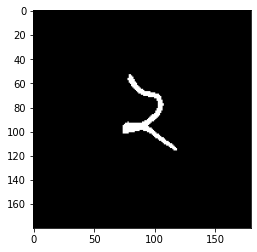

In [8]:
## Displaying a MNIST Image

import matplotlib.pyplot as plt 
import numpy as np

show_img = train_dataset[0][0].numpy().reshape(180, 180)
plt.imshow(show_img, cmap='gray')

### Step #1 : Design your model using class

In [9]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        #1st hidden layer
        self.fc1 = nn.Linear(input_size, 200)
        self.relu_1 = nn.ReLU()
        
        #2nd hidden layer
        self.fc2 = nn.Linear(200, 200)
        self.relu_2 = nn.ReLU()

        

        

        ### Output layer: 200 --> 10
        self.fc_out = nn.Linear(200, num_classes)



    def forward(self, x):
        ### 1st hidden layer
        out  = self.fc1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
         ### 2nd hidden layer
        out  = self.fc2(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_2(out)

      

        logits  = self.fc2(out)

        probas = F.softmax(logits, dim=1)
        return [logits, probas]

In [10]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (fc1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): ReLU()
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (fc_out): Linear(in_features=200, out_features=10, bias=True)
)

###Step #2 : Construct loss and optimizer (select from PyTorch API)

Unlike linear regression, we do not use MSE here, we need Cross Entropy Loss to calculate our loss before we backpropagate and update our parameters.

`criterion = nn.CrossEntropyLoss() ` 

It does 2 things at the same time.

1. Computes softmax ([Logistic or Sigmoid]/softmax function)
2. Computes Cross Entropy Loss

In [14]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

###Step #3 : Training: forward, loss, backward, step

In [15]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)
        #labels =labels.flatten()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 
        
        

        
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)
                labels = labels.to(device)
               # labels =labels.flatten()
                

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)
                #print(correct)
                #print(total)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.0033793449401855. Accuracy: 37.15520790448744
Iteration: 1000. Loss: 1.5773643255233765. Accuracy: 43.536434746809384
Iteration: 1500. Loss: 1.3447788953781128. Accuracy: 50.14409221902017
Iteration: 2000. Loss: 1.2849918603897095. Accuracy: 54.71387402223137
Iteration: 2500. Loss: 1.0853629112243652. Accuracy: 57.53396459448333
Iteration: 3000. Loss: 0.9952907562255859. Accuracy: 64.96500617538082
Iteration: 3500. Loss: 0.7427974939346313. Accuracy: 66.8176204199259
Iteration: 4000. Loss: 0.42527803778648376. Accuracy: 70.0494030465212
Iteration: 4500. Loss: 0.5831571817398071. Accuracy: 70.09057225195554
Iteration: 5000. Loss: 0.41656240820884705. Accuracy: 71.5726636475916
Iteration: 5500. Loss: 0.3874768316745758. Accuracy: 72.64306298888431
Iteration: 6000. Loss: 0.22851896286010742. Accuracy: 74.14573898723755
Iteration: 6500. Loss: 0.23348203301429749. Accuracy: 73.36352408398518
Iteration: 7000. Loss: 0.10485337674617767. Accuracy: 74.4339234252779
Itera

[2.0033793449401855, 1.5773643255233765, 1.3447788953781128, 1.2849918603897095, 1.0853629112243652, 0.9952907562255859, 0.7427974939346313, 0.42527803778648376, 0.5831571817398071, 0.41656240820884705, 0.3874768316745758, 0.22851896286010742, 0.23348203301429749, 0.10485337674617767, 0.13916625082492828, 0.10687166452407837, 0.15936508774757385, 0.061352215707302094, 0.05167527124285698, 0.020032193511724472, 0.04523327946662903, 0.03526182845234871, 0.02177540585398674, 0.01756671816110611, 0.020200587809085846, 0.008827212266623974, 0.013056439347565174, 0.0072506750002503395, 0.010619794949889183, 0.005954395513981581, 0.005291441455483437]


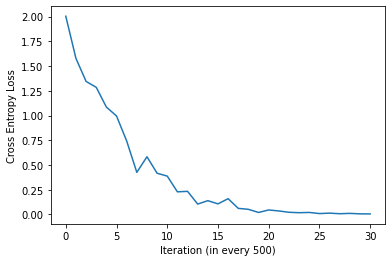

In [16]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [17]:
from google.colab import drive

drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/4238data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
